<a href="https://colab.research.google.com/github/kraken114/Colab/blob/main/3D_Deep_learning_2_%D1%81%D1%82%D1%80_70_%D0%9F%D0%BE%D0%B4%D0%B3%D0%BE%D0%BD%D0%BA%D0%B0_%D0%BF%D0%BE%D0%BB%D0%B8%D0%B3%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B9_%D1%81%D0%B5%D1%82%D0%BA%D0%B8_%D0%BA_%D0%BE%D0%B1%D0%BB%D0%B0%D0%BA%D1%83_%D1%82%D0%BE%D1%87%D0%B5%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ГЛАВА 3**

# **Оборачиваем облако точек полигональной сеткой**



---



---



---



---



---



---



# **Это необходимо для использования графики в Colab**

**1. Вначале необходимо импортировать все требующиеся модули Python:**

In [ ]:
%%capture
# блок установки pytorch3d
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
%%capture
!pip install open3d
!wget https://graphics.stanford.edu/~mdfisher/Data/Meshes/bunny.obj
import numpy as np
import plotly.graph_objects as go
import open3d
from pytorch3d.io import load_ply
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# https://linkhs.github.io/Colab/Open3D/Open3D_visualization.html
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == open3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == open3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()
# draw_geometries('/content/cube.ply')

# **Конец необхдимого**



---



---



---



---



---



---



# **Пример программирования 3D-отрисовки**

стр. 75

**pytorch3d.loss.champer_distance** - функция потерь при подгонке полигональных сеток к облаку точек

**pytorch3d.ops.sample_points_from_meshes** - функция которыя случайно выбирает несколько точек из полигональной сетки для подгонки (служи и оптимизатором)

Функция потерь + функции потерь с разными штрафами за неровность:

1. **pytorch3d.loss.mesh_laplacian_smoothing** - функция потерь с учетом сглаживания Лаплас (похоже здесь суммарная функция потерь pytorch3d.loss.champer_distance + штраы зе неровную поверхность Лапласа(сглаживание Лапласа))

2. **pytorch3d.loss.mesh_normal_consistency** - тоже, что и предыдущая штука,только вместо сглаживания Лапласа - Функция потери с учетом согласованности нормалей полигональной сетки

3. **pytorch3d.loss.mesh_edge_loss** - функция потери с учетом длин ребер

# **Реализация подгонки полигональной сетки**

In [ ]:
import os
import sys
import torch
from pytorch3d.io import load_ply, save_ply
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
chamfer_distance,
mesh_edge_loss,
mesh_laplacian_smoothing,
mesh_normal_consistency,
)
import numpy as np



---
**Визуализация входного облака точек**





---


# **Загрузка облака точек!!!**

In [ ]:
# https://linkhs.github.io/Colab/Open3D/Open3D_visualization.html
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == open3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == open3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

In [ ]:
mesh_file = '/content/pedestrian.ply'
print('Визуализация полигональной сетки с помощью Open3D')
mesh = open3d.io.read_point_cloud(mesh_file)

open3d.visualization.draw_geometries = draw_geometries # replace function
open3d.visualization.draw_geometries([mesh])
print('Загрузка того же файла с помощью PyTorch3D')
vertices, faces = load_ply(mesh_file)
print('Тип vertices = ', type(vertices))
print('Тип faces = ', type(faces))
print('vertices = ', vertices)
print('faces = ', faces)

Визуализация полигональной сетки с помощью Open3D


Загрузка того же файла с помощью PyTorch3D
Тип vertices =  <class 'torch.Tensor'>
Тип faces =  <class 'torch.Tensor'>
vertices =  tensor([[-0.6639,  6.3572,  2.1298],
        [-0.7410,  6.4097,  2.1504],
        [-0.7647,  6.0695,  1.3548],
        [-0.6838,  6.3177,  1.0733],
        [-0.8261,  6.2366,  1.3942],
        [-0.7228,  6.2273,  1.7460],
        [-0.7188,  6.2741,  1.0664],
        [-0.8678,  6.2487,  1.3982],
        [-0.7633,  6.3135,  1.7717],
        [-0.7484,  6.2707,  1.0664],
        [-0.8941,  6.2233,  1.3933],
        [-0.8044,  6.3200,  1.7750],
        [-0.7827,  6.2268,  1.0596],
        [-0.9352,  6.2310,  1.3964],
        [-0.8421,  6.2996,  1.7706],
        [-0.6637,  6.2861,  2.0621],
        [-0.8300,  6.2823,  1.0702],
        [-0.9651,  6.1673,  1.3831],
        [-0.7141,  6.3818,  2.0954],
        [-0.8656,  6.2496,  1.0654],
        [-0.9965,  6.1168,  1.3729],
        [-0.7568,  6.3998,  2.1030],
        [-0.8907,  6.1486,  1.0486],
        [-1.0412,  



---

---



---





---



---



**3. Загружаем облако точек для работы**

In [ ]:
verts, faces = load_ply("/content/pedestrian.ply")
# verts = verts.to(device)
# faces = faces.to(device)

**4. Затем выполняем нормализацию и меняем очертания тензоров для**
**последующей обработки:**

In [ ]:
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale
verts = verts[None, :, :]

In [ ]:
verts.shape

torch.Size([1, 239, 3])

**5. На следующем шаге создаем сеточную переменную с именем** **src_mesh (начальная сетка для подгонки)**

In [ ]:
src_mesh = ico_sphere(4, device) # начальная сфера полигональная

**6. Определить переменную deform_verts. Переменная **
**deform_verts – это тензор смещений вершин**

In [ ]:
# стр. 77
src_vert = src_mesh.verts_list()
deform_verts = torch.full(src_vert[0].shape, 0.0,
                          requires_grad=True)

**7. Определяем SGD-оптимизатор**

In [ ]:
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

**8. Задаем набор весов для 4-х функций потери**

In [ ]:
w_chamfer = 1.0
w_edge = 1.0
w_normal = 0.01
w_laplacian = 0.1

**9. Обучаем**

In [ ]:
for i in range(0, 2000):
  print("i = ", i)
  # Инициализируем оптимизатор
  optimizer.zero_grad()
  #
  new_src_mesh = src_mesh.offset_verts(deform_verts)
  # Отбираем точки с поверхности каждой полигональной сетки
  sample_trg = verts # целево облако точек
  sample_src = sample_points_from_meshes(new_src_mesh, verts.shape[1]) # предсказанное облако точек
  # Сравниваем два множества облаков точек,
  # вычисляя (a) фасочную потерю
  loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
  # и (b) длину ребер предсказанной полигональной сетки
  loss_edge = mesh_edge_loss(new_src_mesh)
  # согласованность нормалей полигональной стеки
  loss_normal = mesh_normal_consistency(new_src_mesh)
  # лапласианово сглаживание полигональной сетки
  loss_laplacian = mesh_laplacian_smoothing(new_src_mesh,
  method='uniform')
  # Взвешенная сумма потерей
  loss = (loss_chamfer * w_chamfer
          + loss_edge * w_edge
          + loss_normal * w_normal
          + loss_laplacian * w_laplacian)
  # Шаг оптимизации
  loss.backward()
  optimizer.step()

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16
i =  17
i =  18
i =  19
i =  20
i =  21
i =  22
i =  23
i =  24
i =  25
i =  26
i =  27
i =  28
i =  29
i =  30
i =  31
i =  32
i =  33
i =  34
i =  35
i =  36
i =  37
i =  38
i =  39
i =  40
i =  41
i =  42
i =  43
i =  44
i =  45
i =  46
i =  47
i =  48
i =  49
i =  50
i =  51
i =  52
i =  53
i =  54
i =  55
i =  56
i =  57
i =  58
i =  59
i =  60
i =  61
i =  62
i =  63
i =  64
i =  65
i =  66
i =  67
i =  68
i =  69
i =  70
i =  71
i =  72
i =  73
i =  74
i =  75
i =  76
i =  77
i =  78
i =  79
i =  80
i =  81
i =  82
i =  83
i =  84
i =  85
i =  86
i =  87
i =  88
i =  89
i =  90
i =  91
i =  92
i =  93
i =  94
i =  95
i =  96
i =  97
i =  98
i =  99
i =  100
i =  101
i =  102
i =  103
i =  104
i =  105
i =  106
i =  107
i =  108
i =  109
i =  110
i =  111
i =  112
i =  113
i =  114
i =  115
i =  116
i =  117
i =  118
i =  119
i =  120
i =  121
i =  122
i =

**10. Затем извлекаем полученные вершины и грани из переменной** **new_src_mesh, а затем восстанавливаем** **изначальное местоположение центра и масштаб:**

In [ ]:
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)
final_verts = final_verts * scale + center

**11. Наконец, полученная сеточная модель сохраняется в ** **PLY-файле deform1.ply:**

In [ ]:
whale
/content/bunny.obj.1

In [ ]:
# Сохранить предсказанную сетку с помощью save_ply
final_obj = os.path.join("/content/", "whale_1.ply")
save_ply(final_obj, final_verts, final_faces, ascii=True)

**11.1 Смотрим, что получилось:**

In [ ]:
mesh_file = '/content/whale_1.ply'
print('Оптимизированная деформируемая сеточная модель.')
print('Обратите внимание, что теперь гораздо больше точек,чем у изначального входного облака точек')
mesh = open3d.io.read_point_cloud(mesh_file)

open3d.visualization.draw_geometries = draw_geometries # replace function
open3d.visualization.draw_geometries([mesh])
print('Загрузка того же файла с помощью PyTorch3D')
vertices, faces = load_ply(mesh_file)
print('Тип vertices = ', type(vertices))
print('Тип faces = ', type(faces))
print('vertices = ', vertices)
print('faces = ', faces)

Оптимизированная деформируемая сеточная модель.
Обратите внимание, что теперь гораздо больше точек,чем у изначального входного облака точек


Загрузка того же файла с помощью PyTorch3D
Тип vertices =  <class 'torch.Tensor'>
Тип faces =  <class 'torch.Tensor'>
vertices =  tensor([[-0.9794,  6.2511,  1.4780],
        [-0.7118,  6.3157,  1.0970],
        [-0.9540,  6.1061,  1.2329],
        ...,
        [-1.0455,  6.2900,  0.5378],
        [-1.0450,  6.2919,  0.5298],
        [-1.0615,  6.2918,  0.5440]])
faces =  tensor([[   0,  646,  643],
        [   0,  643,  642],
        [   0,  642,  644],
        ...,
        [2536, 2535, 2537],
        [2558, 2556, 2557],
        [2525, 2524, 2523]])


**Этопалучится без функций сглаживания, т.е. если (см. ниже):**

**w_chamfer = 1.0**

**w_edge = 0.0**

**w_normal = 0.00**

**w_laplacian = 0.0**

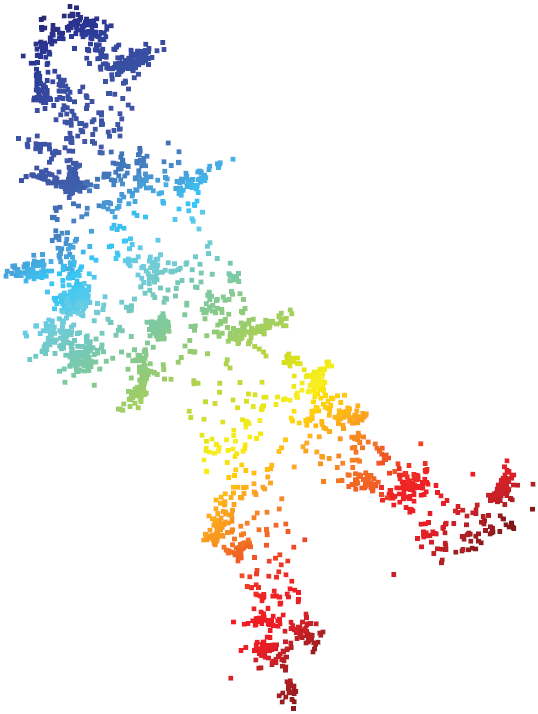